# Notes on Computing the Rollout Acquisition Function
## Considerations
- Using expected improvement as a control variate doesn't behave as anticipated. You can inspect the difference between acquisitions evaluated with or without this control variate by setting the named argument in, simulate_trajectory, variance_reduction to false or true, i.e.: `simulate_trajectory(..., variance_reduction=true)`. The logic for implementing the EI control variate is located at `src/rollout.jl`.

In [1]:
using Distributions
using LinearAlgebra
using Plots
using Roots

All the necessary imports for our computations of interest

In [2]:
include("../testfns.jl")
include("../rollout.jl")
include("../utils.jl")

to (generic function with 1 method)

## Basic Setup

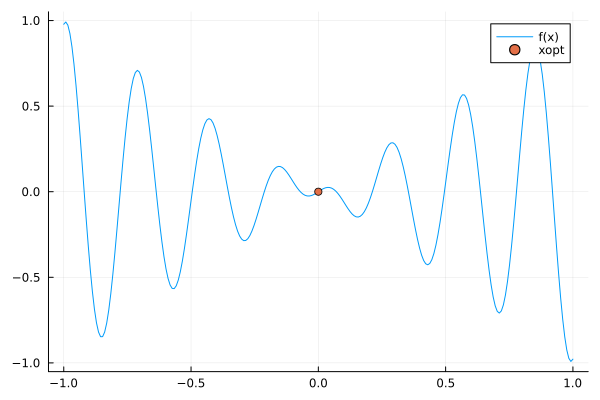

In [3]:
# Visualize 1D test function
testfn = scale(TestLinearCosine1D(1., 22.2), 1.)
# testfn = TestQuadratic1D()
# testfn = TestConstant(lbs=[0.], ubs=[1.])
tplot(testfn)

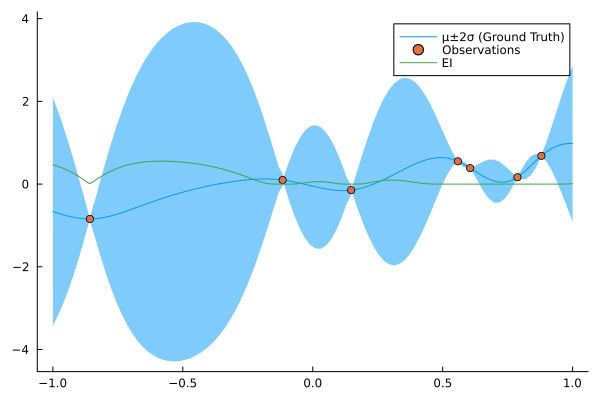

In [4]:
MC_SAMPLES = 1000
NUMBER_OF_STARTS = 8
HORIZON = 1
USE_LDS = true
INITIAL_SAMPLES = 7

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-6
# ψ = kernel_matern52(θ)
ψ = kernel_scale(kernel_matern52, [5., .25])

lbs, ubs = get_bounds(testfn)
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Initialize the trajectory parameters
tp = initialize_trajectory_parameters(
    start=initial_guesses[:, 1],
    horizon=HORIZON,
    mc_iterations=MC_SAMPLES,
    use_low_discrepancy_sequence=USE_LDS,
    lowerbounds=lbs,
    upperbounds=ubs
)

Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.15;; .85;;]
yinit = testfn(Xinit)

# Fit surrogate with hyperparameters learned via MLE
sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2)
plot1D(sur, xmin=first(lbs), xmax=first(ubs))
EIb = [sur([x]).EI for x in domain]
plot!(domain, EIb, label="EI")

## On Perturbing the jth Policy Solve

Given some policy solve $r_j$, we have the following dependence structure on previous observations:

$$
\newcommand{\bfx}{\mathbf{x}}
\newcommand{\bfr}{\mathbf{r}}
\bfr_j(\bfx_j; \bfx_0, y_0, \ldots, \bfx_{j-1}, y_{j-1}) = 0
$$

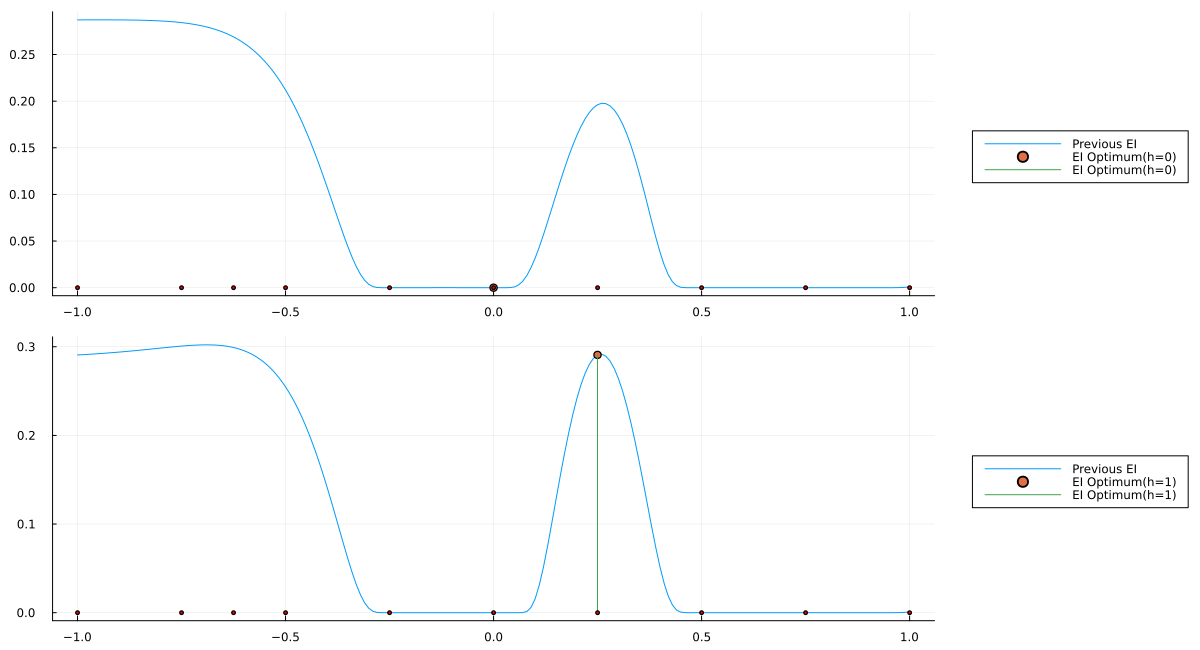

In [6]:
# Create the trajectory
# AT = AdjointTrajectory(sur, tp.x0, tp.h)
AT = AdjointTrajectory(base_surrogate=sur, start=tp.x0, horizon=tp.h)
stochastic_sampler = StochasticObservable(surrogate=AT.fs, stdnormal=get_samples_rnstream(tp, sample_index=1), max_invocations=HORIZON + 1)
deterministic_sampler = DeterministicObservable(testfn, max_invocations=HORIZON + 1)
attach_observable!(AT, stochastic_sampler)

# Adjoint Rollout
adjoint_rollout!(AT, lowerbounds=tp.lbs, upperbounds=tp.ubs, xstarts=initial_guesses, get_observation=get_observable(AT))

all_plots = []
for upto_index in 0:HORIZON
    EIx = zeros(length(domain))
    for (i, xx) in enumerate(domain)
        EIx[i] = AT.fs([xx], fantasy_index=upto_index-1).EI
    end
    p = plot(domain, EIx, label="Previous EI")
    target_location = first(AT.fs.X[:, INITIAL_SAMPLES + upto_index + 1])
    scatter!([target_location], [AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    plot!([target_location, target_location], [0., AT.fs([target_location], fantasy_index=upto_index-1).EI], label="EI Optimum(h=$upto_index)")
    scatter!(p, initial_guesses, zeros(NUMBER_OF_STARTS), color=:red, label=nothing, markersize=2)
    push!(all_plots, p)
end

plot(all_plots..., layout=(length(all_plots), 1), size=(1200, 325 * (HORIZON + 1)), legend=:outerright)

In [6]:
resolutions = zeros(MC_SAMPLES)
gresolutions = zeros(testfn.dim, MC_SAMPLES)

dense_acquisition = zeros(length(domain))
dense_forward_acquisition = zeros(length(domain))
dense_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_forward_gradient_acquisition = zeros(testfn.dim, length(domain))
fd_gradient_acquisition = zeros(testfn.dim, length(domain))
dense_std = zeros(length(domain))
h = 1e-6

for (index, xx) in enumerate(domain)
    print("|")
    tp.x0 = [xx]
    # Adjoint mode
    dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = simulate_adjoint_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    )
    # dense_acquisition[index], dense_std[index], dense_gradient_acquisition[:, index] = deterministic_simulate_trajectory(
    #     sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )

    # Finite difference mode
    tp.x0 = [xx - h]
    aminus, _, _ = simulate_adjoint_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    )
    # aminus, _, _ = deterministic_simulate_trajectory(
    #     sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )

    tp.x0 = [xx + h]
    aplus, _, _ = simulate_adjoint_trajectory(
        sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions
    )
    # aplus, _, _ = deterministic_simulate_trajectory(
    #     sur, tp, inner_solve_xstarts=initial_guesses, resolutions=resolutions, gradient_resolutions=gresolutions, testfn=testfn
    # )
    fd_gradient_acquisition[:, index] .= (aplus - aminus) / 2h

    # Forward mode
    # tp_fm.x0 = [xx]
    # dense_forward_acquisition[index], _, dense_forward_gradient_acquisition[:, index] = simulate_trajectory(
    #     sur, tp_fm, initial_guesses, αxs=resolutions, ∇αxs=gresolutions
    # )
end

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

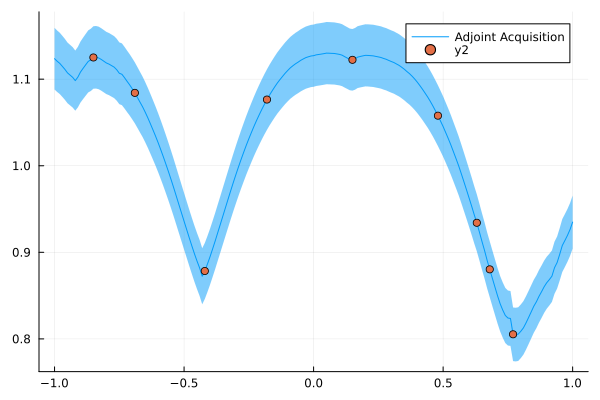

In [10]:
# plot(domain, stdize(dense_acquisition), ribbons=dense_std ./ sqrt(MC_SAMPLES), label="α(h=$HORIZON)")
slice = 1:length(domain)
plot(domain[slice], dense_acquisition[slice], ribbons=dense_std[slice] / sqrt(MC_SAMPLES), label="Adjoint Acquisition")
# zeros_indices = find_zeros(dense_gradient_acquisition[1, slice])
# scatter!(domain[zeros_indices], dense_acquisition[zeros_indices])
# plot!(domain[slice], dense_forward_acquisition[slice], label="MOGP Acquisition")

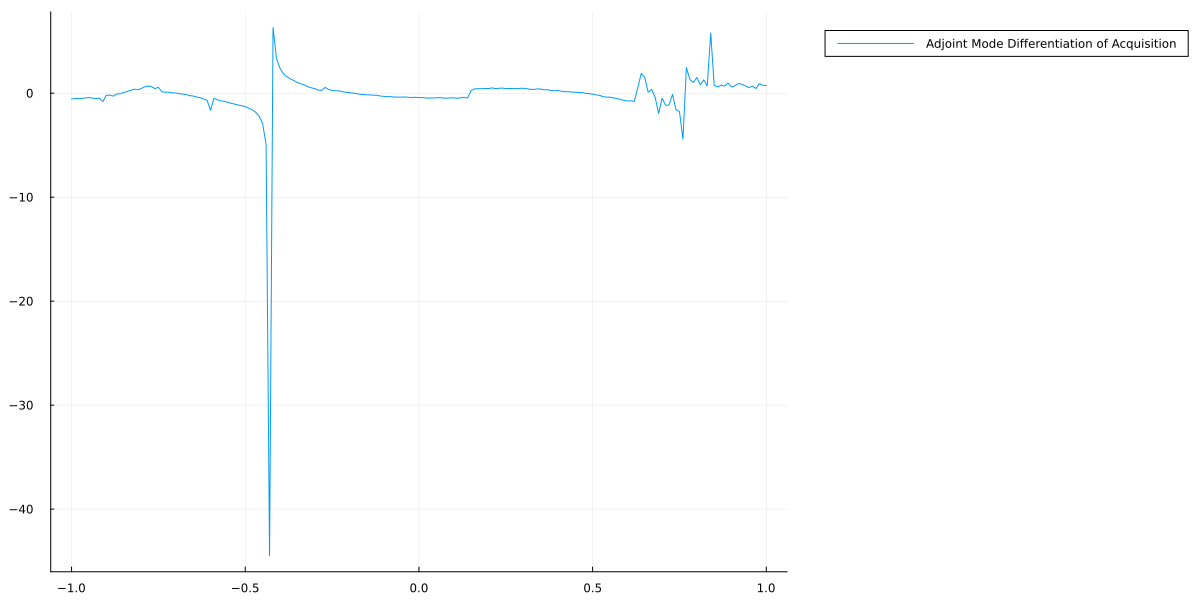

In [9]:
# plot(domain[slice], fd_gradient_acquisition[1, slice], label="Finite Difference of Acquisition")
plot(domain[slice], dense_gradient_acquisition[1, slice], label="Adjoint Mode Differentiation of Acquisition", legend=:outertopright, size=(1200, 600))
# plot!(domain[slice], dense_forward_gradient_acquisition[1, slice], label="forward dα(h=$HORIZON)")

In [5]:
fmini = minimum(yinit)

function ei_constructor(; σtol=1e-8)
    function ei(μ, σ, θ)
        if σ < σtol
            return 0.
        end
        improvement = fmini - μ - θ[1]
        z = improvement / σ
        standard_normal = Distributions.Normal(0, 1)
        
        expected_improvement = improvement*Distributions.cdf(standard_normal, z) + σ*Distributions.pdf(standard_normal, z)
        return expected_improvement
    end

    return ei
end

function cost_constrained_ei_constructor(; σtol=1e-8)
    function cost_constrained_ei(μ, σ, θ)
        if σ < σtol
            return 0.
        end
        improvement = fmini - μ - θ[1]
        z = improvement / σ
        standard_normal = Distributions.Normal(0, 1)
        
        expected_improvement = improvement*Distributions.cdf(standard_normal, z) + σ*Distributions.pdf(standard_normal, z)
        return expected_improvement
    end

    return cost_constrained_ei
end

ei_constructor (generic function with 1 method)

In [11]:
gsur = FlexibleSurrogate(ψ, Xinit, yinit, BasePolicy(ei_constructor()), σn2=σn2)
domain = dense_1D_discretization(lb=first(lbs), ub=first(ubs), stepsize=.01)
explorations = [0., .3]

acquisitions = [similar(domain) for _ in 1:length(explorations)]
∇acquisitions = [similar(domain) for _ in 1:length(explorations)]
Hacquisitions = [similar(domain) for _ in 1:length(explorations)]


for (j, exploration) in enumerate(explorations)
    for (i, xx) in enumerate(domain)
        gsx = gsur([xx], [exploration])
        acquisitions[j][i] = gsx.α
        ∇acquisitions[j][i] = first(gsx.∇α)
        Hacquisitions[j][i] = first(gsx.Hα)
    end
end

In [12]:
fs = [x -> first(gsur([x], [ep]).∇α) for ep in explorations]

# Function to find all roots in an interval [lb, ub]
function find_all_zeros(f, lb, ub; num_subintervals=100, tol=1e-7)
    # Subdivide the interval into smaller segments
    x_vals = range(lb, ub, length=num_subintervals + 1)
    roots = []
    
    # Loop through each adjacent pair of points in the subdivision
    for i in 1:length(x_vals)-1
        x1 = x_vals[i]
        x2 = x_vals[i+1]
        
        # Check if there is a sign change, indicating a possible zero
        if sign(f(x1)) != sign(f(x2))
            # Attempt to find the zero within the subinterval [x1, x2]
            root = find_zero(f, (x1, x2), Roots.Brent(), tol=tol)
            push!(roots, root)
        end
    end
    
    # Return the found roots
    return unique(roots)  # Use unique to avoid duplicates due to floating point precision
end

lb = first(lbs)
ub = first(ubs)

all_roots = [find_all_zeros(f, lb, ub) for f in fs]

2-element Vector{Vector{Any}}:
 [-0.8574909692414597, -0.5836186889893834, -0.11499999999999999, 0.023965999456015054, 0.1475000000005646, 0.30493588307621416, 0.56, 0.6, 0.7056001740520063, 0.79, 0.831212993915183, 0.88]
 [-0.8573818008359055, -0.5736010844095375, -0.11499999999999999, 0.022413472707256646, 0.15, 0.30866317663436643, 0.56, 0.6, 0.704719873597537, 0.79, 0.8321193545874187, 0.88]

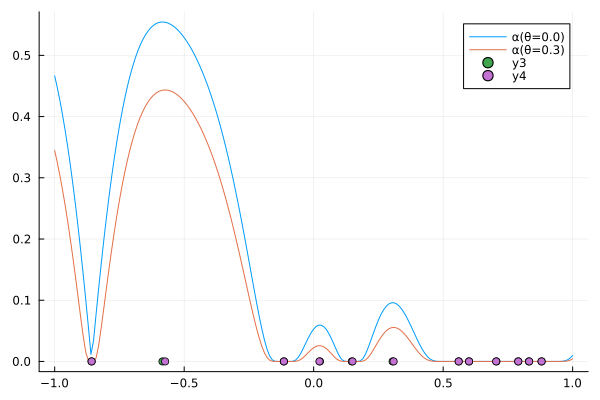

In [13]:
plot()
[plot!(domain, acquisition, label="α(θ=$(explorations[i]))") for (i, acquisition) in enumerate(acquisitions)]
[scatter!(roots, zeros(NUMBER_OF_STARTS)) for roots in all_roots]
plot!()

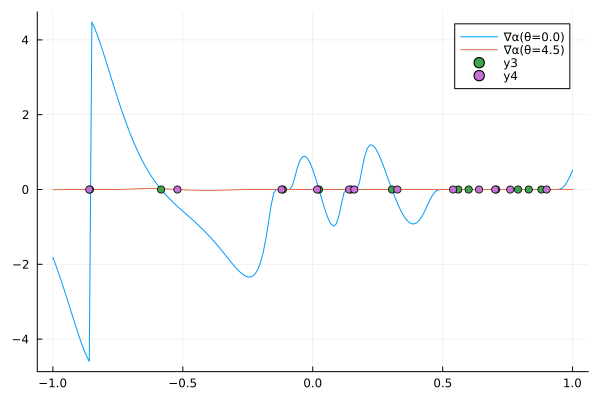

In [10]:
plot()
[plot!(domain, ∇acquisition, label="∇α(θ=$(explorations[i]))") for (i, ∇acquisition) in enumerate(∇acquisitions)]
[scatter!(roots, zeros(NUMBER_OF_STARTS)) for roots in all_roots]
plot!()

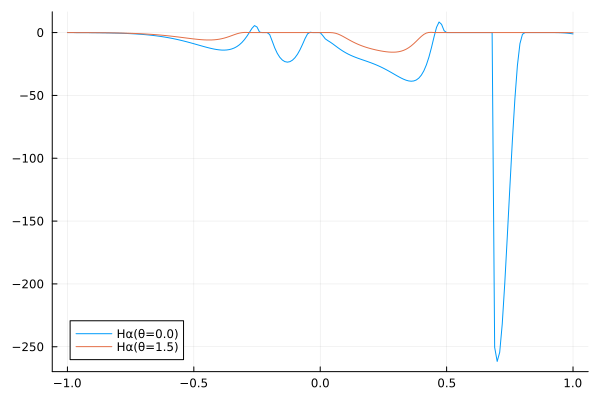

In [44]:
plot()
[plot!(domain, Hacquisition, label="Hα(θ=$(explorations[i]))") for (i, Hacquisition) in enumerate(Hacquisitions)]
plot!()